# روش1

# از روش مثال فرستاده شده

In [ ]:
!curl -LO https://www.kaggle.com/datasets/datascientistsohail/captchaimages1070?select=data
!unzip -qq a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11114    0 11114    0     0  47495      0 --:--:-- --:--:-- --:--:-- 47495
replace data/0CZWM.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_dir = Path("./data/")

images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 1070
Number of labels found: 1070
Number of unique characters: 62
Characters present: {'i', 'W', 'Q', 'j', 'M', 'N', 'o', 'z', 'y', '1', 'G', 'I', 'm', 'H', 'q', 's', '5', 'E', 'L', 'Y', 'U', 'a', '2', '0', 'p', '4', 'w', 'O', 'Z', 'A', 'n', '9', 'x', 'g', 'r', 'X', 'T', 'C', 'D', 't', 'V', 'e', 'c', 'R', 'f', 'J', '8', 'S', 'l', '7', '3', 'k', 'v', 'h', 'F', '6', 'B', 'd', 'K', 'P', 'u', 'b'}


In [ ]:
batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4

max_length = max([len(label) for label in labels])

In [ ]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)


def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]] 
    return x_train, x_valid, y_train, y_valid

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

print(f"X_Train shape: {X_train.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_Train shape: (963,)
y_Train shape: (963,)
X_valid shape: (107,)
y_valid shape: (107,)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

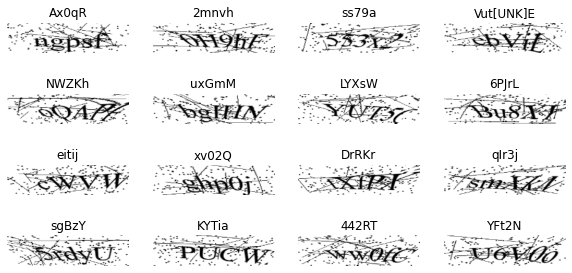

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred
    
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
    
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [ ]:
epochs = 50
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=validation_dataset,epochs=epochs,callbacks=[early_stopping])


# روش2

In [ ]:
import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
import tensorflow as tf

In [ ]:
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [ ]:
t_in = Input(shape=(50, 200, 1))
x = t_in

x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)
x = Dropout(0.4)(x)

t_lstm_in = x
t_out = []

for k in range(0, 5):
    x = Lambda(lambda x: x[:, :, k*5:(k+1)*5,:])(t_lstm_in)
    x = Reshape((1, -1))(x)
    x = LSTM(64, activation='relu')(x)
    x = Dense(48, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(36, activation='softmax', name='char_{}'.format(k))(x)
    t_out.append(x)

In [ ]:
model = Model(inputs=t_in, outputs=t_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 32)  320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 dropout_1 (Dropout)            (None, 25, 100, 32)  0           ['max_pooling2d[0][0]']      

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=2, epochs=10, verbose=True)